In [6]:
# Package
import os

Check working directory.

In [7]:
os.getcwd()

'/home/howsetya/workspace/Bioimage2'

Define a function to load image files and put them in a data frame.

In [ ]:
# Package
import glob, re,
import pandas as pd
from skimage.io import imread, imshow,show

In [17]:
def load_imgs(path):
    files_img = glob.glob(path)
    files_img.sort()
    df_img = pd.DataFrame(columns=['FileName','Image'])
    for file in files_img:
        filename = re.sub(".*/", "", file[:-4])
        img = imread(file) # tifffile plugin for loading compressed tiffs requires imagecodecs
        df_img.loc[len(df_img)] = [filename,img]
        # print(file) # to show progress
        # imshow(img) # to show image
        # show()
    return(df_img)

There are 4 directories of data, namely 2 sets of training and 2 sets of challenge datasets with the following relative path:
1. ./Images/training_BF-C2DL-HSC/01/subset/*.tif
2. ./Images/training_BF-C2DL-HSC/02/subset/*.tif
3. ./Images/challenge_BF-C2DL-HSC/01/subset/*.tif
4. ./Images/challenge_BF-C2DL-HSC/02/subset/*.tif

These are all subsets of the real complete dataset to save time in going through all the data. Each contains around 20% the amount of the complete data (0.2 * ~1700 = ~350 images).

In [18]:
# Set path
# This subset folder contains even fewer images  
path = ('./Images/training_BF-C2DL-HSC/01/subset2/*.tif')

In [19]:
# Load all images in the directory of the path
imgs = load_imgs(path)

In [28]:
# Check the data frame
imgs.shape

(27, 2)

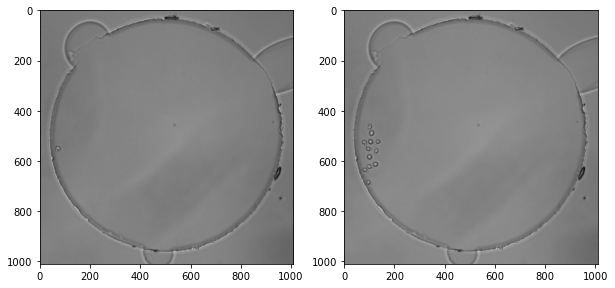

In [29]:
# Check the image
fig, ax = plt.subplots(1,2,figsize=(10, 10))
ax[0].imshow(imgs.iloc[0,1],cmap='gray')
ax[1].imshow(imgs.iloc[26,1],cmap='gray')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt